In [1]:
import os
import re
import pickle
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from  keras . utils  import  to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D,Conv2D, MaxPooling1D, Embedding, Flatten
from keras.models import Model
from keras.initializers import Constant
from keras.layers import Embedding

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd 
train_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_train.csv')
stopwords=pd.read_csv('gdrive/My Drive/Colab Notebooks/Stopwords.csv')
test_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_test.csv')


In [4]:
!git clone -l -s https://github.com/banglakit/bengali-stemmer.git

Cloning into 'bengali-stemmer'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 94 (delta 5), reused 16 (delta 4), pack-reused 69
Unpacking objects: 100% (94/94), done.


In [5]:
!pip install git+https://github.com/banglakit/bengali-stemmer.git    

  Cloning https://github.com/banglakit/bengali-stemmer.git to /tmp/pip-req-build-zywxpn2s
  Running command git clone -q https://github.com/banglakit/bengali-stemmer.git /tmp/pip-req-build-zywxpn2s
  Created wheel for bengali-stemmer: filename=bengali_stemmer-0.0.1-py2.py3-none-any.whl size=6393 sha256=3622886551020fcfad454883ae81b10b0eccb3e0f9b5c798e410ffabf1dcd458
  Stored in directory: /tmp/pip-ephem-wheel-cache-iiwbrvlc/wheels/a1/ad/a1/4ba354059b17c00600a14e13a504e7bdb49f20f2f4e2f3639c
Successfully built bengali-stemmer


In [6]:
!pip install git+https://github.com/banglakit/bengali-stemmer.git    

  Cloning https://github.com/banglakit/bengali-stemmer.git to /tmp/pip-req-build-jrr172id
  Running command git clone -q https://github.com/banglakit/bengali-stemmer.git /tmp/pip-req-build-jrr172id
  Created wheel for bengali-stemmer: filename=bengali_stemmer-0.0.1-py2.py3-none-any.whl size=6393 sha256=8a70e1fd4200024c1194801896b814c44755db19dba4fc62f6118c4351a825ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-dut4jhuw/wheels/a1/ad/a1/4ba354059b17c00600a14e13a504e7bdb49f20f2f4e2f3639c
Successfully built bengali-stemmer


In [7]:
from bengali_stemmer.rafikamal2014 import RafiStemmer
stemmer = RafiStemmer()
stemmer.stem_word('বাংলায়')

'বাংলা'

In [8]:
total_data = train_data
total_data=total_data.append(test_data, ignore_index = True)

In [9]:
macronum=sorted(set(total_data['label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

total_data['label']=total_data['label'].apply(fun)


In [10]:
texts = list(total_data['text'])
labels = list(total_data['label'])


In [11]:
def clean_punct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#|।|’|‘]', r'', sentence)
    cleaned1 = re.sub(r'[.|,|(|)|\|/]', r'', cleaned)
    cleaned = re.sub(r'[০|১|২|৩|৪|৫|৬|৭|৮|৯]', r'', cleaned1)
    cleaned1 = re.sub(r'[-|=]', r' ', cleaned)
    return cleaned1

In [12]:
set_stop = set(stopwords['words'])

In [14]:

def pre_process(data):
    i=0
    str1=' '
    final_string = []
    final_words = []
    all_negative_words = []
    s=''

    for sentence in data:
        filtered_sentence = []

        for w in sentence.split():
            for cleaned_word in clean_punct(w).split():
                if len(cleaned_word)>2:
                    if((cleaned_word) not in set_stop):
                        s = stemmer.stem_word(cleaned_word)
                        if len(s)>2:
                            final_words.append(s)
                            filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue

        str1 = " ".join(filtered_sentence)
        final_string.append(str1)
    return final_string

In [15]:
texts = pre_process(texts)

In [16]:
texts[0]

'সাম্প্রদায়িক সংঘাত মানবিক প্রতিরোধ সাম্প্রদায়িক সংঘাত মানবিক প্রতিরোধফকির ইলিয়াস দেশ থাকি বহুজাতিক বহুভাষিক মানুষ বাস ধর্মাবলম্বী মতাবলম্বী মানুষ কারো কারো মিল চাইল সামান্য বিষ প্রতিদিন দাঙ্গা তেমন হ্যাঁ প্রি পাঠক মার্কিন যুক্তরাষ্ট্র কথা বলছিএ দেশ মানুষ মানুষ বুক পাঁজর চিবি দেশ কঠোর আইন থাক পার পারব পারব কঠিন শাস্তির মুখোমুখি জীবনবাজি রায়ট কেপাক ভারত উপমহাদেশ জন্ম বিভক্ত রায়ট মধ্য কারোর অজানা জন্মইতিহাস জন্ম পাকিস্তান ভারত পরবর্তীকাল বাংলাদেশ ভূখণ্ড দ্বিজাতি তত্ত্ব শত্রু সম্পত্তি আইন মানুষ মানুষ ধর্ম বিভাজন সেভাব পরিকল্পিতভাব সাল ভারত ভাগ অসংখ্য হিন্দু ঘরবাড়ি ছেড় গিয় জিন্নাহর দ্বিজাতি তত্ত্ব ভিত্তি ওঠা দেশ অস্তিত্ব রক্ষা প্রশ্ন প্রথম সাল পূর্বতন পূর্ব পাকিস্তান সাম্প্রদায়িক দাঙ্গ হিন্দু নিরাপত্ত পালি সাল হিন্দু আওয়ামী লীগ ভোট বিশ্বাস দখলদ পাক সেনা সহযোগী প্রবল প্রতিশোধস্পৃহা খুঁজ খুঁজ হিন্দু নিধন চালি হিন্দু বুদ্ধিজীবী সমাজসেবী শ্রদ্ধে ব্যক্তিত্ব ঢাকা বিশ্ববিদ্যালয় জগন্নাথ সহস্রাধিক হিন্দু ছাত্র হত্যা সাল নভেম্বর তারিখ ইউএস সিনেট কমি প্রামাণ্য প্রতিবেদন সিনেটর এডওয়ার্ড কেনেডি লিখ “সব

In [17]:
def load_data(num_words, sequence_length, test_size=0.25, oov_token=None):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    num_classes=6
    y = to_categorical(np.asarray(labels), num_classes)
    tokenizer.fit_on_texts(texts)
    X = tokenizer.texts_to_sequences(texts)
    X = np.array(X)
    # pad sequences with 0's
    X = pad_sequences(X, maxlen=sequence_length)
    # split data to training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    data = {}
    data["X_train"] = X_train
    data["X_test"]= X_test
    data["y_train"] = y_train
    data["y_test"] = y_test
    data["tokenizer"] = tokenizer
    return data

In [18]:
# train_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_train.csv')
import numpy as np

def get_embedding_vectors(word_index, embedding_size=100):
    
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
    with open(f"gdrive/My Drive/Colab Notebooks/bn_glove.{embedding_size}d.txt", encoding="utf8") as f:
        for line in tqdm(f, "Reading GloVe"):
            values = line.split()
            # get the word as the first word in the line
            word = values[0]
            if word in word_index:
                idx = word_index[word]
                # get the vectors as the remaining values in the line
                embedding_matrix[idx] = np.array(values[1:], dtype="float32")
    return embedding_matrix

In [19]:
MAX_SEQUENCE_LENGTH = 11276    #max([len(s.split()) for s in texts]) 
MAX_NUM_WORDS = 109804
vocab_size = MAX_NUM_WORDS
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

data = load_data(MAX_NUM_WORDS , MAX_SEQUENCE_LENGTH,VALIDATION_SPLIT)

In [20]:
len(data['tokenizer'].word_index)

109803

In [21]:
embedding_matrix = get_embedding_vectors( data['tokenizer'].word_index ,EMBEDDING_DIM )

Reading GloVe: 134256it [00:06, 19977.66it/s]


In [23]:
embedding_layer = Embedding(len(data['tokenizer'].word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [24]:
# create the model
embedding_vecor_length = 300
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 11276, 300)        32941200  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 33,102,206
Trainable params: 161,006
Non-trainable params: 32,941,200
_________________________________________________________________
None


In [25]:
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']),batch_size=64, epochs=10, verbose=2)

Epoch 1/10
27/27 - 20s - loss: 1.3647 - accuracy: 0.4839 - val_loss: 1.1019 - val_accuracy: 0.5810
Epoch 2/10
27/27 - 20s - loss: 0.9967 - accuracy: 0.6304 - val_loss: 0.9489 - val_accuracy: 0.6381
Epoch 3/10
27/27 - 20s - loss: 0.8295 - accuracy: 0.6940 - val_loss: 0.9202 - val_accuracy: 0.6381
Epoch 4/10
27/27 - 20s - loss: 0.7216 - accuracy: 0.7452 - val_loss: 0.8117 - val_accuracy: 0.7095
Epoch 5/10
27/27 - 21s - loss: 0.6420 - accuracy: 0.7589 - val_loss: 0.7995 - val_accuracy: 0.7190
Epoch 6/10
27/27 - 21s - loss: 0.5730 - accuracy: 0.8000 - val_loss: 0.7751 - val_accuracy: 0.7310
Epoch 7/10
27/27 - 21s - loss: 0.4963 - accuracy: 0.8345 - val_loss: 0.7521 - val_accuracy: 0.7214
Epoch 8/10
27/27 - 21s - loss: 0.4666 - accuracy: 0.8399 - val_loss: 0.7600 - val_accuracy: 0.7214
Epoch 9/10
27/27 - 21s - loss: 0.4419 - accuracy: 0.8506 - val_loss: 0.7834 - val_accuracy: 0.7024
Epoch 10/10
27/27 - 21s - loss: 0.4141 - accuracy: 0.8613 - val_loss: 0.7394 - val_accuracy: 0.7476


In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confussion_mat(model):
    # Predict the values from the validation dataset
    Y_pred = model.predict(data['X_test'])
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(data['y_test'],axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [27]:
def history2(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


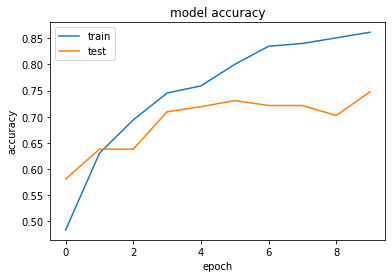

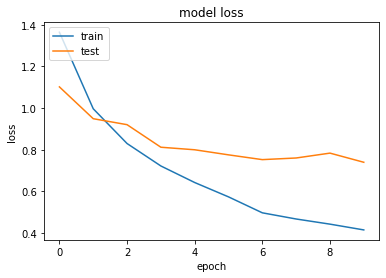

In [28]:
history2(history)

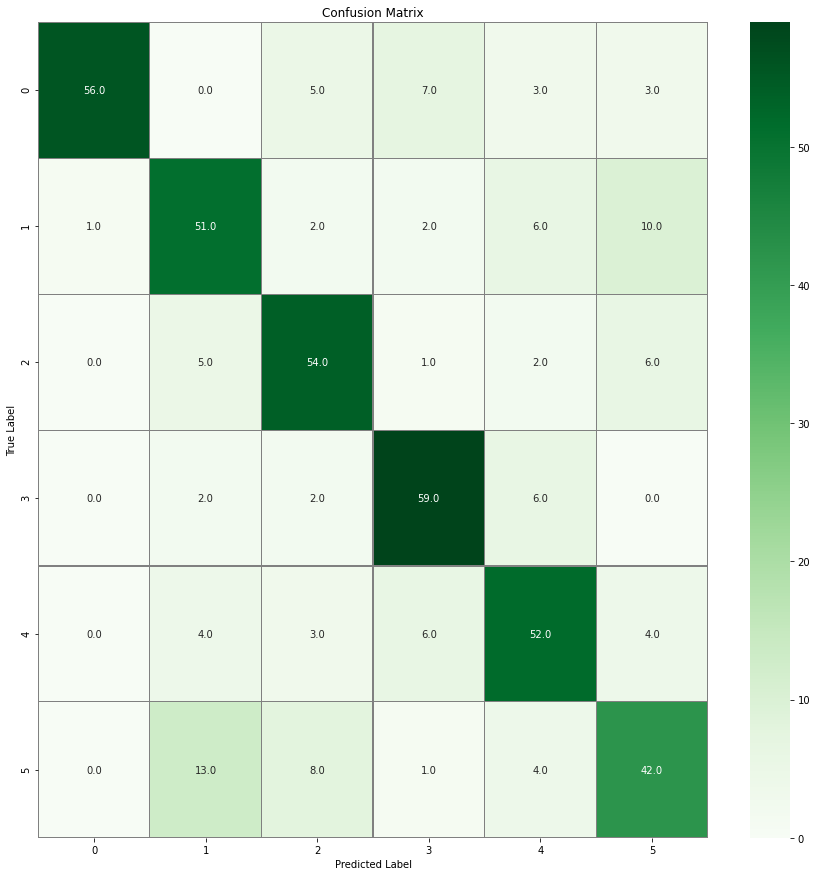

In [29]:
confussion_mat(model)

In [30]:
# check with batch size = 32
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']),batch_size=32, epochs=10, verbose=2)

Epoch 1/10
53/53 - 27s - loss: 0.3720 - accuracy: 0.8732 - val_loss: 0.8568 - val_accuracy: 0.7357
Epoch 2/10
53/53 - 28s - loss: 0.3226 - accuracy: 0.8935 - val_loss: 0.8092 - val_accuracy: 0.7548
Epoch 3/10
53/53 - 28s - loss: 0.2818 - accuracy: 0.9125 - val_loss: 0.8511 - val_accuracy: 0.7500
Epoch 4/10
53/53 - 28s - loss: 0.1838 - accuracy: 0.9435 - val_loss: 0.9005 - val_accuracy: 0.7262
Epoch 5/10
53/53 - 28s - loss: 0.1677 - accuracy: 0.9607 - val_loss: 0.8616 - val_accuracy: 0.7595
Epoch 6/10
53/53 - 28s - loss: 0.1318 - accuracy: 0.9625 - val_loss: 0.8655 - val_accuracy: 0.7357
Epoch 7/10
53/53 - 27s - loss: 0.1569 - accuracy: 0.9548 - val_loss: 0.9690 - val_accuracy: 0.7143
Epoch 8/10
53/53 - 27s - loss: 0.1157 - accuracy: 0.9696 - val_loss: 0.9344 - val_accuracy: 0.7405
Epoch 9/10
53/53 - 27s - loss: 0.0797 - accuracy: 0.9815 - val_loss: 0.9773 - val_accuracy: 0.7286
Epoch 10/10
53/53 - 27s - loss: 0.0501 - accuracy: 0.9899 - val_loss: 0.9821 - val_accuracy: 0.7500


In [31]:
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']),batch_size=128, epochs=10, verbose=2)

Epoch 1/10
14/14 - 17s - loss: 0.0372 - accuracy: 0.9940 - val_loss: 0.9554 - val_accuracy: 0.7571
Epoch 2/10
14/14 - 17s - loss: 0.0253 - accuracy: 0.9964 - val_loss: 0.9410 - val_accuracy: 0.7524
Epoch 3/10
14/14 - 17s - loss: 0.0192 - accuracy: 0.9964 - val_loss: 0.9568 - val_accuracy: 0.7786
Epoch 4/10
14/14 - 16s - loss: 0.0166 - accuracy: 0.9970 - val_loss: 0.9666 - val_accuracy: 0.7762
Epoch 5/10
14/14 - 17s - loss: 0.0150 - accuracy: 0.9976 - val_loss: 0.9764 - val_accuracy: 0.7738
Epoch 6/10
14/14 - 17s - loss: 0.0139 - accuracy: 0.9976 - val_loss: 0.9888 - val_accuracy: 0.7762
Epoch 7/10
14/14 - 17s - loss: 0.0131 - accuracy: 0.9976 - val_loss: 0.9933 - val_accuracy: 0.7786
Epoch 8/10
14/14 - 17s - loss: 0.0122 - accuracy: 0.9982 - val_loss: 1.0024 - val_accuracy: 0.7810
Epoch 9/10
14/14 - 17s - loss: 0.0111 - accuracy: 0.9982 - val_loss: 1.0132 - val_accuracy: 0.7738
Epoch 10/10
14/14 - 17s - loss: 0.0111 - accuracy: 0.9982 - val_loss: 1.0301 - val_accuracy: 0.7762
